In [22]:
import pandas as pd
import numpy as np
import pyross
import matplotlib.pyplot as plt

In [23]:
df = pd.read_csv('data-by-day.csv', parse_dates = ['date_of_interest'])

In [24]:
df['daily_death_rate'] = df['DEATH_COUNT']/df['CASE_COUNT']
df['cum_case'] = df['CASE_COUNT'].cumsum()
df['cum_death'] = df['DEATH_COUNT'].cumsum()
df['death_rate'] = df['cum_death']/df['cum_case']
df['growth_rate'] = df['CASE_COUNT'].div(df['cum_case'].shift(1))
gamma = 1/7
df['Rt'] = (df['growth_rate']/gamma)+1
df['ratio'] = df['cum_case'].div(df['cum_case'].shift(1))

In [25]:
M = 1                  # the SIR model has no age structure
Ni = 18804000*np.ones(M)   # so there is only one age group 
N = np.sum(Ni)         # and the total population is the size of this age group

r0 = df['Rt'].mean()
beta  = r0*(gamma+0.006)            # infection rate 
gIa   = gamma+0.006            # removal rate of asymptomatic infectives 
gIs   = gamma+0.006            # removal rate of symptomatic infectives 
alpha = 0              # fraction of asymptomatic infectives 
fsa   = 1              # Fraction by which symptomatic individuals do not self isolate


Ia0 = np.array([0])     # the SIR model has only one kind of infective 
Is0 = np.array([1])     # we take these to be symptomatic 
R0  = np.array([0])     # and assume there are no removed individuals initially 
S0  = N-(Ia0+Is0+R0)    # so that the initial susceptibles are obtained from S + Ia + Is + R = N

# there is no contact structure
def contactMatrix(t):   
    return np.identity(M) 

# duration of simulation and data file
Tf = 430;  Nt=430; 

# instantiate model
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
model = pyross.deterministic.SIR(parameters, M, Ni)

# simulate model 
#data = model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nt)
data = model.simulator(np.concatenate((S0, Ia0, Is0)), contactMatrix, Tf, Nt) # another possibility

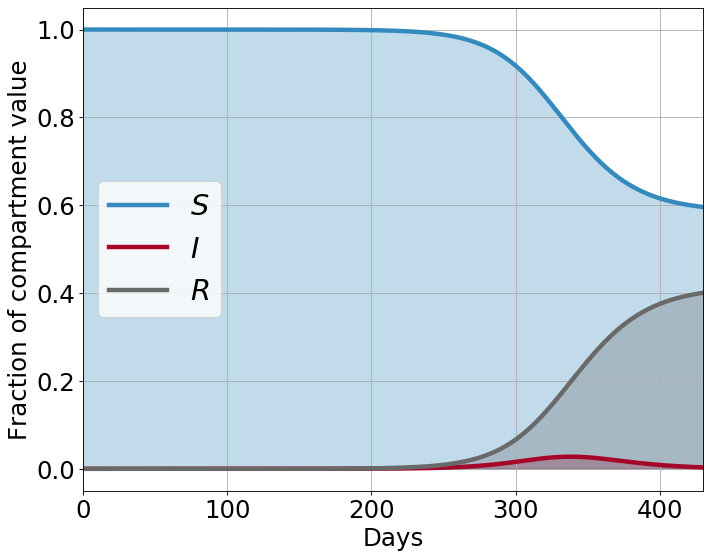

In [26]:
# plot the data and obtain the epidemic curve
S  = data['X'][:,0].flatten()
Ia = data['X'][:,1].flatten()
Is = data['X'][:,2].flatten()
t = data['t']


fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})


plt.fill_between(t, 0, S/N, color="#348ABD", alpha=0.3)
plt.plot(t, S/N, '-', color="#348ABD", label='$S$', lw=4)

plt.fill_between(t, 0, Is/N, color='#A60628', alpha=0.3)
plt.plot(t, Is/N, '-', color='#A60628', label='$I$', lw=4)

R=N-S-Ia-Is; plt.fill_between(t, 0, R/N, color="dimgrey", alpha=0.3)
plt.plot(t, R/N, '-', color="dimgrey", label='$R$', lw=4)

plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Fraction of compartment value')
plt.xlabel('Days');


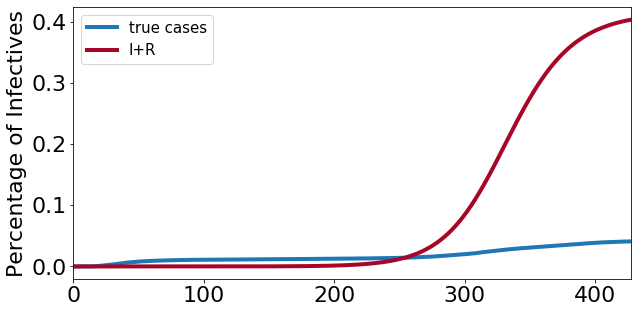

In [27]:
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df['cum_case']/18804000, lw=4,label = 'true cases')
plt.ylabel('Percentage of Infectives')
plt.xticks(np.arange(0, 430, 100))
#plt.axvline(x=17,color='k', linestyle='--')
#plt.text(17,0.1,'lockdown',rotation=90,fontsize = 15)
plt.plot((Is+R)/18804000, '-', color='#A60628', label='I+R', lw=4)
#plt.plot((Ia+Is)/18804000, '--', color='#A60628', label='Ia+Is', lw=4)
#plt.ylim([0, 1e7])
plt.xlim([0, 428])
plt.legend(fontsize=15)
plt.show()